__Aim:__ building an extended version of `primekg` that include OMIM phenotypes and genes. 

In __PrimeKG__ there is no __"source"__ dedicated to OMIM (neither [July 2023] nor [Feb 2023] versions). Here, I aim to gather relevant info and append OMIM gene and phenotype links to the current PrimeKG graph. 

__History:__
- During my work in another project, I noticed there are no OMIM nodes in the current graph – https://github.com/mims-harvard/PrimeKG/issues/9
- After a discussion with Dr. Marinka Zitnik ([@marinkaz](https://github.com/marinkaz)), she suggested that I can make this work as a pull request to the PrimeKG repo.
- From this effort, I added a function called `get_nodes_by_source` to TDC – https://github.com/mims-harvard/TDC/pull/207

__Futute works:__
- Previously, I aimed to work with OMIM textual information together with Dr. Hadi Amiri ([@amirieb](https://github.com/amirieb)). Thus, scripts I used here also extracts up-to-date textual information from OMIM which can be used for BERT representation toward finding OMIM links with other datasets.

__Tasks:__
- [x] Load a `primeKG` version to be extended.
- [x] Explore `primeKG` and distill relevant information.
- [x] Append/find links between `MONDO`/`HPO` terms and OMIM genes/phenotypes.
- [x] Unify nomenclature to refine the knowledge graph by adding desired relationships.
- [x] Include/keep links between genes and HPO, OMIM, etc.
- [ ] Compare the two graphs, before and after including info from OMIM database.

__Datasets:__
- Mondo Disease Ontology – https://mondo.monarchinitiative.org/
- Human Phenotype Ontology – https://hpo.jax.org/app/
- Online Mendelian Inheritance in Man (OMIM) 

In [1]:
import re
import pandas as pd
import numpy as np
import igraph as ig
import sys
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles

sys.path.append('..')

from scripts.utils import write_data, read_data
from datasets.processing_scripts import omim_tools
from datasets.processing_scripts.mondo_obo_parser import OBOReader

# https://blakeaw.github.io/2020-05-25-improve-matplotlib-notebook-inline-res/
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

datasets_path = '../datasets'

/var/folders/sx/tm64_b5n1vl137l9nnryg2zm0000gn/T/ipykernel_53550/3497697614.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


## Gather Datasets

In another notebook (see [this link](https://github.com/abearab/PrimeKG/blob/488434dcebc2a8ca7bd53b533edf4cfd93b36bac/datasets/omim/omim-api.ipynb)), I shared scripts and notes about downloading updated version of relevant OMIM data.

### OMIM

In [2]:
data_omim = read_data(f'{datasets_path}/OMIM/OMIM_FULL_May_2023.json.gz')

done in 5.047s


___
Let's see what kind of information is covered in OMIM:

In [3]:
# omim_tools.get_omim_info(data_omim)

In [4]:
# omim_tools.get_omim_phenotype_info(data_omim)

In [5]:
# {k for i,j in omim_tools.get_omim_info(data_omim,'externalLinks') for k in j.keys()}

___

load annotations for OMIM entries

In [6]:
# read mim2gene
mim2gene = pd.read_csv(
    f'{datasets_path}/OMIM/mim2gene.txt',sep='\t',skiprows=5,header=None,dtype=str
)[[0,1,3]].replace(np.nan, '')
mim2gene.columns = ['mimNumber','mimType','geneSymbol']

# read mimTitles
mimTitles = pd.read_csv(
    f'{datasets_path}/OMIM/mimTitles.txt',sep='\t',skiprows=2,header=0,dtype=str
).replace(np.nan, '').rename(columns={'MIM Number':'mimNumber'})
mimTitles = mimTitles[~mimTitles.iloc[:,0].str.contains('#')]
mimTitles = mimTitles.iloc[:,1:]

sanity check

In [7]:
all(mimTitles.mimNumber == mim2gene.mimNumber)

True

In [8]:
mim_meta = mim2gene.copy()

mim_meta['mimLabel'] = ''
mim_meta.loc[mim_meta.geneSymbol != "",'mimLabel'] = mim_meta.loc[mim_meta.geneSymbol != "",'geneSymbol']
mim_meta.loc[mim_meta.geneSymbol == "",'mimLabel'] = mimTitles.loc[mim_meta.geneSymbol == "",'Preferred Title; symbol'].str.split('; ').str[-1]
mim_meta['mimTitle'] = mimTitles['Preferred Title; symbol'].apply(lambda x: '; '.join(x.split('; ')[:-1]))
mim_meta.loc[mim_meta['mimTitle'].eq(''),'mimTitle'] = mim_meta.loc[mim_meta['mimTitle'].eq(''),'mimLabel']

and Phenotypic-Series ...

In [9]:
mimPS_Titles = pd.read_csv(
    f'{datasets_path}/OMIM/OMIM-Phenotypic-Series-Titles-all.tsv',sep='\t',header=0,skiprows=3,dtype=str
)#.replace(np.nan, '').rename(columns={'MIM Number':'mimNumber'})

### PrimeKG 
https://github.com/mims-harvard/PrimeKG#using-primekg

<img src="https://pbs.twimg.com/media/FSWtqpVXMAA5Rui?format=jpg&name=medium" width=500>

In [10]:
# wget -O kg.csv https://dataverse.harvard.edu/api/access/datafile/6180620

In [11]:
def read_primekg(filepath=f'{datasets_path}/kg.csv.gz'):
    primekg = pd.read_csv(filepath, low_memory=False)
    return primekg

In [12]:
# added to TDC as `get_nodes_by_source` – https://github.com/mims-harvard/TDC/pull/207

def get_PrimeKG_nodes_by_source(primekg, source):
    out = pd.concat([
        primekg.query(
            f"x_source == '{source}' | y_source == '{source}'"
        )[['x_index','x_id','x_type','x_name','x_source']].rename(columns={'x_index':'index','x_id':'id','x_type':'type','x_name':'name','x_source':'source'}),

        primekg.query(
            f"x_source == '{source}' | y_source == '{source}'"
        )[['y_index','y_id','y_type','y_name','y_source']].rename(columns={'y_index':'index','y_id':'id','y_type':'type','y_name':'name','y_source':'source'})
    ]).query(f'source == "{source}"').drop_duplicates().reset_index(drop=True).sort_values('index')

    return out

In [13]:
primekg = read_primekg()

In [14]:
# primekg.columns.to_list()

### Mondo Disease Ontology

> Stable release versions
> - http://purl.obolibrary.org/obo/mondo.obo
> - http://purl.obolibrary.org/obo/mondo.json
> - http://purl.obolibrary.org/obo/mondo.owl



<!-- > ##### Rare Disease analysis in Mondo
To answer the question of ‘How many rare diseases are there?’ we analyzed terms in Mondo to get a total count of Rare Diseases as defined in Mondo Disease Ontology (Mondo).
> - https://mondo.monarchinitiative.org/pages/analysis/
 -->
 
<!-- - https://mondo.monarchinitiative.org/
- https://github.com/monarch-initiative/mondo
- https://obofoundry.org/ontology/mondo -->

<!-- https://github.com/monarch-initiative/mondo/releases/tag/v2023-07-03 -->

<!-- http://aber-owl.net/ontology/MONDO/#/Download

    Description	A global community effort to harmonize multiple disease resources to yield a coherent merged ontology.

    Version	
    Release date	2023-02-13T12:31:28.980986Z
 -->

I'm using this code to parse mondo `obo` file – https://github.com/mims-harvard/PrimeKG/blob/main/datasets/processing_scripts/mondo_obo_parser.py

In [15]:
pth = "../datasets/mondo/mondo.obo"
data_mondo = [*iter(OBOReader(pth))]

closeMatch not added for: property_value: closeMatch http://purl.bioontology.org/ontology/ICD10CM/Q82.2


In [16]:
mondo_terms = pd.DataFrame([{'id':x.item_id, 
                             'name':x.name, 
                             'definition':x.definition,
                             'is_obsolete':x.is_obsolete,
                             'xrefs':str(x.xrefs).replace('{','').replace('}',''),
                             'replacement_id': x.replaced_by} for x in data_mondo])

print(mondo_terms.shape[0], "total terms")
print(mondo_terms.query('is_obsolete==False').shape[0], 'not obsolete')

26508 total terms
23314 not obsolete


### HPO

- HPO toolkit – https://github.com/TheJacksonLaboratory/hpo-toolkit
- pyHPO – https://pypi.org/project/pyhpo/ | https://centogene.github.io/pyhpo/
> A Python library to work with, analyze, filter and inspect the Human Phenotype Ontology

<!-- If we want to replace Mondo with HPO, we need Mondo-HPO links and maybe Mondo-OMIM and Mondo-gene relationships.  -->

In [17]:
from pyhpo import Ontology

# initilize the Ontology ()
ont = Ontology()

In [18]:
ont_df = ont.to_dataframe()

In [19]:
def get_omim_for_hpo_term(hpoid):
    return {str(x.toJSON(verbose = True)['id']) for x in Ontology.get_hpo_object(hpoid).omim_diseases}

## Extract relevant info

### MONDO terms with OMIM / OMIMPS links

In [20]:
mondo_omim_terms = mondo_terms[mondo_terms.xrefs.str.contains('OMIM:')].reset_index(drop=True)
mondo_omim_terms['omim'] = mondo_omim_terms.xrefs.apply(lambda x: re.findall("OMIM:[0-9]+",x)[0])
mondo_omim_terms = mondo_omim_terms[['id','omim']]

In [21]:
mondo_omimps_terms = mondo_terms[mondo_terms.xrefs.str.contains('OMIMPS:')].reset_index(drop=True)
mondo_omimps_terms['omimps'] = mondo_omimps_terms.xrefs.apply(lambda x: re.findall("OMIMPS:[0-9]+",x)[0])
mondo_omimps_terms = mondo_omimps_terms[['id','omimps']]

### Evaluate OMIM info in MONDO

#### Overlap all OMIM IDs and OMIM IDs in MONDO.

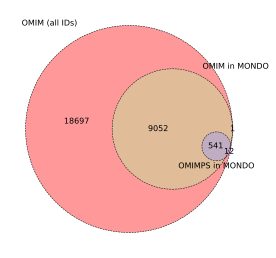

In [22]:
fig, ax = plt.subplots(1, 1,figsize=(4,4),)
subsets = [
    set(mim2gene.mimNumber), 
    set(mondo_omim_terms['omim'].str.replace('OMIM:','').astype(int).astype(str)),
    set(mondo_omimps_terms['omimps'].str.replace('OMIMPS:','').astype(int).astype(str))
]


p = venn3(
    subsets,
    set_labels=(
        'OMIM (all IDs)',
        'OMIM in MONDO',
        'OMIMPS in MONDO'
    ),
    set_colors=('r', 'g', 'b'), 
    # alpha = 0.5,
    ax=ax);

for text in p.set_labels:
    text.set_fontsize(8)
for x in range(len(p.subset_labels)):
    if p.subset_labels[x] is not None:
        p.subset_labels[x].set_fontsize(8)

venn3_circles(
    subsets,
    linestyle='dashed', linewidth=.5, color='k',ax=ax);

fig.tight_layout()
plt.show()

#### Check OMIM gene entries in Mondo

In [23]:
mim2gene.reset_index().set_index('mimNumber').loc[
    list(
        set(mondo_omim_terms.omim.str.replace('OMIM:','').astype(int).astype(str)) & set(mim2gene.mimNumber)
   ),:
].groupby('mimType').size()

mimType
gene                           2
moved/removed                118
phenotype                   7853
predominantly phenotypes    1620
dtype: int64

In [24]:
mim2gene.reset_index().set_index('mimNumber').loc[
    list(
        set(mondo_omimps_terms.omimps.str.replace('OMIMPS:','').astype(int).astype(str)) & set(mim2gene.mimNumber)
   ),:
].groupby('mimType').size()

mimType
moved/removed                 1
phenotype                   550
predominantly phenotypes      2
dtype: int64

<div class="alert alert-block alert-info"> <b>Conclusion:</b> OMIM gene entries are not covered by MONDO .</div>

### Compare Mondo with PrimeKG 

#### OMIM in Mondo

/Users/abearab/anaconda3/envs/mamba/envs/primekg/lib/python3.10/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


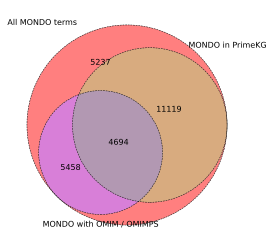

In [25]:
fig, ax = plt.subplots(1, 1,figsize=(4,4),)
subsets = [
    set(mondo_terms.id.astype(int).astype(str)),
    set(get_PrimeKG_nodes_by_source(primekg, 'MONDO').id), 
    set(pd.concat([mondo_omim_terms, mondo_omimps_terms]).id.astype(int).astype(str))
]

p = venn3(
    subsets,
    set_labels=(
        'All MONDO terms',
        'MONDO in PrimeKG',
        'MONDO with OMIM / OMIMPS'
    ),
    set_colors=('r', 'g', 'b'), 
    alpha = 0.5,
    ax=ax);

for text in p.set_labels:
    text.set_fontsize(8)
for x in range(len(p.subset_labels)):
    if p.subset_labels[x] is not None:
        p.subset_labels[x].set_fontsize(8)

venn3_circles(
    subsets,
    linestyle='dashed', linewidth=.5, color='k',ax=ax);



fig.tight_layout()
plt.show()

<div class="alert alert-block alert-warning"> <b>Note:</b> This is most likely cuased by MONDO version difference since I downloaded MONDO datasets myself and that can be different from what has been used in PrimeKG. </div>

#### OMIMPS in OMIM vs. MONDO

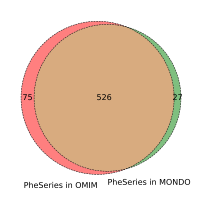

In [26]:
fig, ax = plt.subplots(1, 1,figsize=(3,3),)
subsets = [
    set(omim_tools.get_omim_phenotype_info(data_omim,'phenotypicSeriesNumber').phenotypicSeriesNumber),
    set(mondo_omimps_terms.omimps.str.replace('OMIMPS:','PS'))
]

p = venn2(
    subsets,
    set_labels=(
        'PheSeries in OMIM',
        'PheSeries in MONDO',
        # 'PheSeries in MONDO',
    ),
    set_colors=('r', 'g'), 
    alpha = 0.5,
    ax=ax);

for text in p.set_labels:
    text.set_fontsize(8)
for x in range(len(p.subset_labels)):
    if p.subset_labels[x] is not None:
        p.subset_labels[x].set_fontsize(8)

venn2_circles(
    subsets,
    linestyle='dashed', linewidth=.5, color='k',ax=ax);



fig.tight_layout()
plt.show()

## Build OMIM knowledge graph

Here, I'm mimicking __PrimeKG__'s dataframe format to build an extendable graph from gathered OMIM information.

In [27]:
def get_empty_kg(primekg,indices):
    """return empty dataframe mimicking __PrimeKG__'s dataframe format
    """
    return pd.DataFrame(
        '',
        columns=primekg.columns,
        index=indices
    )

### 1. Mondo-OMIM links

#### 1.1 OMIM

In [28]:
Mondo_OMIM_kg = get_empty_kg(primekg,mondo_omim_terms.index)

In [29]:
Mondo_OMIM_kg['x_id'] = mondo_omim_terms['omim'].str.replace('OMIM:','').astype(int)
Mondo_OMIM_kg['y_id'] = mondo_omim_terms['id'].astype(int)
Mondo_OMIM_kg['x_source'] = 'OMIM'
Mondo_OMIM_kg['y_source'] = 'MONDO'

Mondo_OMIM_kg['relation'] = 'mim_disease'
Mondo_OMIM_kg['display_relation'] = 'linked to'

remove mims if not in OMIM ...

In [30]:
Mondo_OMIM_kg.query(
    f"x_id not in {mim_meta.mimNumber.astype(int).to_list()}"
).x_id.to_list()

[620151]

In [31]:
Mondo_OMIM_kg = Mondo_OMIM_kg.query(
    f"x_id in {mim_meta.mimNumber.astype(int).to_list()}"
).reset_index(drop=True)

add `x_name` and `x_type` info

In [32]:
Mondo_OMIM_kg['x_name'] = mim_meta.set_index('mimNumber').loc[
    Mondo_OMIM_kg.x_id.astype(str).to_list(),
    'mimLabel'
].to_list()

In [33]:
Mondo_OMIM_kg['x_type'] = mim_meta.set_index('mimNumber').loc[
    Mondo_OMIM_kg.x_id.astype(str).to_list(),
    'mimType'
].to_list()

#### 1.1 OMIMPS

In [34]:
Mondo_OMIMPS_kg = get_empty_kg(primekg,mondo_omimps_terms.index)

In [35]:
Mondo_OMIMPS_kg['x_id'] = mondo_omimps_terms['omimps'].str.replace('OMIMPS:','PS')
Mondo_OMIMPS_kg['y_id'] = mondo_omimps_terms['id'].astype(int)
Mondo_OMIMPS_kg['x_source'] = 'OMIMPS'
Mondo_OMIMPS_kg['y_source'] = 'MONDO'

Mondo_OMIMPS_kg['relation'] = 'mim_phenotypic_series_disease'
Mondo_OMIMPS_kg['display_relation'] = 'linked to'

remove PS ids if not in OMIM ...

In [36]:
Mondo_OMIMPS_kg.query(f"x_id not in {mimPS_Titles['Phenotypic Series number'].to_list()}").x_id.to_list()

['PS610799',
 'PS156850',
 'PS616814',
 'PS300000',
 'PS117550',
 'PS608808',
 'PS617711',
 'PS105500']

In [37]:
Mondo_OMIMPS_kg = Mondo_OMIMPS_kg.query(
    f"x_id in {mimPS_Titles['Phenotypic Series number'].to_list()}"
).reset_index(drop=True)

add `x_name` and `x_type` info

In [38]:
Mondo_OMIMPS_kg['x_name'] = mimPS_Titles.set_index(['Phenotypic Series number']).loc[
    Mondo_OMIMPS_kg.x_id.to_list(),'Phenotypic Series Title'
].to_list()

In [39]:
Mondo_OMIMPS_kg['x_type'] = 'phenotypic_series'

### 2.Gene-OMIM links

#### 2.1 OMIM gene entries

In [40]:
omim_genes = mim_meta.query('mimType == "gene"').reset_index(drop=True)

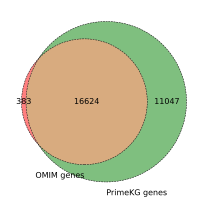

In [41]:
fig, ax = plt.subplots(1, 1,figsize=(3,3),)
subsets = [
    set(omim_genes.mimLabel),
    set(get_PrimeKG_nodes_by_source(primekg,'NCBI').name)
]

p = venn2(
    subsets,
    set_labels=(
        'OMIM genes',
        'PrimeKG genes',
    ),
    set_colors=('r', 'g'), 
    alpha = 0.5,
    ax=ax);

for text in p.set_labels:
    text.set_fontsize(8)
for x in range(len(p.subset_labels)):
    if p.subset_labels[x] is not None:
        p.subset_labels[x].set_fontsize(8)

venn2_circles(
    subsets,
    linestyle='dashed', linewidth=.5, color='k',ax=ax);

fig.tight_layout()
plt.show()

___
missing genes!

In [42]:
omim_genes_missing = list(
    set(omim_genes.mimLabel) - set(get_PrimeKG_nodes_by_source(primekg,'NCBI').name)
)
omim_genes_missing.sort()

In [43]:
len(omim_genes_missing)

383

<div class="alert alert-block alert-warning"> <b>Warning:</b> I'm not sure why these genes are missing in PrimeKG. These can be added in future revisions. </div>

In [44]:
omim_genes_missing[:3]

['A11', 'ACPS', 'ACTMAP']

e.g. this gene is available in NCBI 

ACTMAP – https://www.ncbi.nlm.nih.gov/gene/284325

___

cleaning ...

In [45]:
omim_genes_v2 = omim_genes.query(f'mimLabel not in {omim_genes_missing}').reset_index(drop=True)

___

In [46]:
gene_OMIM_kg = get_empty_kg(primekg,omim_genes_v2.index)

In [47]:
gene_OMIM_kg['x_id'] = omim_genes_v2['mimNumber'].astype(int)
gene_OMIM_kg['x_name'] = omim_genes_v2['mimLabel'].to_list()
gene_OMIM_kg['x_source'] = 'OMIM'
gene_OMIM_kg['x_type'] = omim_genes_v2['mimType'].to_list()

gene_OMIM_kg['y_source'] = 'NCBI'

gene_OMIM_kg['relation'] = 'mim_gene'
gene_OMIM_kg['display_relation'] = 'linked to'

add `y_index`, `y_type`, and `y_name` info

In [48]:
gene_OMIM_kg['y_index'] = get_PrimeKG_nodes_by_source(primekg,'NCBI').set_index('name').loc[
    gene_OMIM_kg.x_name,'index'].to_list()

In [49]:
gene_OMIM_kg['y_type'] = get_PrimeKG_nodes_by_source(primekg,'NCBI').set_index('name').loc[
    gene_OMIM_kg.x_name,'type'].to_list()

In [50]:
gene_OMIM_kg['y_name'] = get_PrimeKG_nodes_by_source(primekg,'NCBI').set_index('name').loc[
    gene_OMIM_kg.x_name,:].index.to_list()

#### 2.2 Phenotype-Gene Relationships

In [51]:
#omim_tools.get_omim_phenotype_info(data_omim,'approvedGeneSymbols')

In [52]:
omim_pheno_gene = [] 

for mim_1, phenotypeMapList in omim_tools.get_omim_info(data_omim,'phenotypeMapList'):
    for pm in phenotypeMapList:
        mim_2 = str(pm['phenotypeMap']['mimNumber'])
        omim_pheno_gene.append((mim_1, mim_2))

omim_pheno_gene = pd.DataFrame(omim_pheno_gene,columns=['mim_1','mim_2'])

___

In [53]:
mim2gene.query(
    f'mimNumber in {omim_pheno_gene.mim_2.to_list()}'
).groupby(['mimType']).size()

mimType
gene              4764
gene/phenotype      17
phenotype           20
dtype: int64

In [54]:
mim2gene.query(
    f'mimNumber in {omim_pheno_gene.mim_1.to_list()}'
).groupby(['mimType','geneSymbol']).size()

mimType                   geneSymbol
phenotype                               6419
predominantly phenotypes                   6
dtype: int64

___

make the sub-graph:

In [55]:
pheno_gene_OMIM_kg = get_empty_kg(primekg,omim_pheno_gene.index)

In [56]:
pheno_gene_OMIM_kg['x_id'] = omim_pheno_gene['mim_1'].astype(int)
pheno_gene_OMIM_kg['x_source'] = 'OMIM'
pheno_gene_OMIM_kg['x_type'] = mim_meta.set_index('mimNumber').loc[omim_pheno_gene['mim_1'],'mimType'].to_list()

pheno_gene_OMIM_kg['y_id'] = omim_pheno_gene['mim_2'].astype(int)
pheno_gene_OMIM_kg['y_source'] = 'OMIM'
pheno_gene_OMIM_kg['y_type'] = mim_meta.set_index('mimNumber').loc[omim_pheno_gene['mim_2'],'mimType'].to_list()

pheno_gene_OMIM_kg['relation'] = 'mim_mim'
pheno_gene_OMIM_kg['relation'] = 'phenotype_map'
pheno_gene_OMIM_kg['display_relation'] = 'associated with'

___
add `x_name` info

In [57]:
sum(pheno_gene_OMIM_kg.x_type == 'gene')

0

okay, non of `x` nodes are genes! I'll label them with full title ... (I noticed some phenotype abbreviation didn't make sense so I continue with full title)

In [58]:
pheno_gene_OMIM_kg['x_name'] = mim_meta.set_index('mimNumber').loc[omim_pheno_gene['mim_1'],'mimTitle'].to_list()

___
add `y_name` info

In [59]:
pheno_gene_OMIM_kg.groupby('y_type').size()# == 'gene'

y_type
gene              7194
gene/phenotype      45
phenotype           20
dtype: int64

Most `y` nodes are genes so I just use the `mimLabel` column to label them ...

In [60]:
pheno_gene_OMIM_kg['y_name'] = mim_meta.set_index('mimNumber').loc[omim_pheno_gene['mim_2'],'mimLabel'].to_list()

### 3.OMIM-OMIMPS

In [61]:
pheno_series = omim_tools.get_omim_phenotype_info(data_omim,'phenotypicSeriesNumber')

some values in `phenotypicSeriesNumber` needs extra data cleaning :)

In [62]:
pheno_series[pheno_series.phenotypicSeriesNumber.str.contains(',')].head()

,mimNumber,phenotypicSeriesNumber
61,615911,"PS105400,PS105550"
62,619141,"PS105400,PS105550"
63,616439,"PS105400,PS105550"
64,105550,"PS105400,PS105550"
65,619132,"PS105400,PS105550"


In [63]:
pheno_series_v2 = []

for _,mim_num,mim_ps_num in pheno_series.itertuples():
    if ',' in mim_ps_num:
        for mim_ps_num_iter in mim_ps_num.split(','):
            pheno_series_v2.append((mim_num,mim_ps_num_iter))
    else:
        pheno_series_v2.append((mim_num,mim_ps_num))

pheno_series_v2 = pd.DataFrame(pheno_series_v2,columns=pheno_series.columns)

In [64]:
PS_OMIM_kg = get_empty_kg(primekg,pheno_series_v2.index)

In [65]:
PS_OMIM_kg['x_id'] = pheno_series_v2['mimNumber'].astype(int)
PS_OMIM_kg['x_type'] = mim_meta.set_index('mimNumber').loc[pheno_series_v2['mimNumber'],'mimType'].to_list()
PS_OMIM_kg['x_source'] = 'OMIM'
PS_OMIM_kg['x_name'] = mim_meta.set_index('mimNumber').loc[pheno_series_v2['mimNumber'],'mimTitle'].to_list()

PS_OMIM_kg['y_id'] = pheno_series_v2['phenotypicSeriesNumber']
PS_OMIM_kg['y_source'] = 'OMIMPS'
PS_OMIM_kg['y_type'] = 'phenotypic_series'
PS_OMIM_kg['y_name'] = mimPS_Titles.set_index('Phenotypic Series number').loc[pheno_series_v2.phenotypicSeriesNumber,'Phenotypic Series Title'].to_list()

PS_OMIM_kg['relation'] = 'mim_phenotypic_series'
PS_OMIM_kg['display_relation'] = 'members'

In [66]:
PS_OMIM_kg.groupby('x_type').size()

x_type
phenotype    4111
dtype: int64

### 4.HPO-OMIM-sets

In [67]:
# get_omim_for_hpo_term(1507)

In [68]:
hpo_omim_map = []

for hpo_id in get_PrimeKG_nodes_by_source(primekg,'HPO').id:
    hpo_mim_ids = get_omim_for_hpo_term(int(hpo_id))
    if len(hpo_mim_ids) > 1:
        for mim_id in hpo_mim_ids:
            hpo_omim_map.append((hpo_id,mim_id))

hpo_omim_map = pd.DataFrame(hpo_omim_map,columns=['HPO','OMIM'])

In [69]:
hpo_omim_map.OMIM.isin(mim_meta.mimNumber).all()

True

good!

In [70]:
HPO_OMIM_kg = get_empty_kg(primekg,hpo_omim_map.index)

In [71]:
HPO_OMIM_kg['x_id'] = hpo_omim_map.OMIM.astype(int)
HPO_OMIM_kg['x_type'] = mim_meta.set_index('mimNumber').loc[hpo_omim_map.OMIM,'mimType'].to_list()
HPO_OMIM_kg['x_source'] = 'OMIM'
HPO_OMIM_kg['x_name'] = mim_meta.set_index('mimNumber').loc[hpo_omim_map.OMIM,'mimTitle'].to_list()

HPO_OMIM_kg['y_id'] = get_PrimeKG_nodes_by_source(primekg,'HPO').set_index('id').loc[hpo_omim_map.HPO.to_list(),].index.to_list()
HPO_OMIM_kg['y_source'] = 'HPO'
HPO_OMIM_kg['y_type'] = get_PrimeKG_nodes_by_source(primekg,'HPO').set_index('id').loc[hpo_omim_map.HPO.to_list(),'type'].to_list()
HPO_OMIM_kg['y_name'] = get_PrimeKG_nodes_by_source(primekg,'HPO').set_index('id').loc[hpo_omim_map.HPO.to_list(),'name'].to_list()

HPO_OMIM_kg['relation'] = 'mim_phenotype'
HPO_OMIM_kg['display_relation'] = 'associated with'

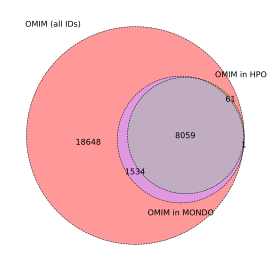

In [86]:
fig, ax = plt.subplots(1, 1,figsize=(4,4),)
subsets = [
    set(mim2gene.mimNumber), 
    set(HPO_OMIM_kg.x_id.astype(str)),
    set(mondo_omim_terms['omim'].str.replace('OMIM:','').astype(int).astype(str)),
]


p = venn3(
    subsets,
    set_labels=(
        'OMIM (all IDs)',
        'OMIM in HPO',
        'OMIM in MONDO'
    ),
    set_colors=('r', 'g', 'b'), 
    # alpha = 0.5,
    ax=ax);

for text in p.set_labels:
    text.set_fontsize(8)
for x in range(len(p.subset_labels)):
    if p.subset_labels[x] is not None:
        p.subset_labels[x].set_fontsize(8)

venn3_circles(
    subsets,
    linestyle='dashed', linewidth=.5, color='k',ax=ax);

fig.tight_layout()
plt.show()

### concat all subgraphs of OMIM-kg

In [72]:
OMIM_kg = pd.concat([
    Mondo_OMIM_kg, Mondo_OMIMPS_kg, 
    gene_OMIM_kg, pheno_gene_OMIM_kg,
    PS_OMIM_kg,
    HPO_OMIM_kg
]).reset_index(drop=True)

<div class="alert alert-block alert-warning"> <b>Note:</b> Some columns (e.g. `x_id`/`y_id`) should be reconsidered by using harmonized integration of the two graphs.</div>

___
#### basic stats

In [73]:
print(f'# of new edges: {OMIM_kg.shape[0]}')
print(f'# of new node: {get_PrimeKG_nodes_by_source(OMIM_kg,"OMIM").shape[0]}')

# of new edges: 612283
# of new node: 32862


In [74]:
OMIM_kg.groupby('relation').size()

relation
mim_disease                        9599
mim_gene                          16636
mim_phenotype                    574128
mim_phenotypic_series              4111
mim_phenotypic_series_disease       550
phenotype_map                      7259
dtype: int64

In [75]:
OMIM_kg.groupby('display_relation').size()

display_relation
associated with    581387
linked to           26785
members              4111
dtype: int64

## Extend PrimeKG with OMIM-KG

In [76]:
primekg_plus = pd.concat([primekg, OMIM_kg]).reset_index(drop=True)

In [119]:
# get_PrimeKG_nodes_by_source(primekg,'MONDO').set_index('id')['index'].loc[Mondo_OMIM_kg.x_id]

<div class="alert alert-block alert-warning"> <b>Note:</b> The current `relations` can be more in depth in later revisions. </div>

# 

In [70]:
%load_ext watermark

In [71]:
%watermark

Last updated: 2023-08-10T19:54:00.959862-07:00

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.11.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [72]:
%watermark --iversions

sys       : 3.10.9 (main, Jan 11 2023, 09:18:20) [Clang 14.0.6 ]
numpy     : 1.21.5
pandas    : 1.4.2
matplotlib: 3.5.1
re        : 2.2.1

